<a href="https://colab.research.google.com/github/MatheusRocha0/Demand-Forecasting/blob/main/US_Demand_For_Gasoline_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Project: Demand Forecasting
 
## Fictional Context
 
**Disclaimer**: the context I will present here is not real, the company and the CEO are all not real and only exist on my mind.
 
I was hired by a company that sells gasoline for a consult to help them in their transition to a data-driven culture. They wanted me to help them to predict which would be the demand for gasoline in the next weeks so they could better prepare for the situation.
 
That is why in this project I am going to use Data Science concepts and technologies to forecast demand.
 
# About the Dataset
 
The dataset I will be using in this project brings informations about gasoline in United States, such as demand and production in different locations.
 
**Here is the link to download this dataset for your own purposes: https://bit.ly/3oAcrmj**

# Imports

In [203]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

In [204]:
%matplotlib inline
warnings.filterwarnings("ignore")

In [205]:
df = pd.read_csv("https://github.com/MatheusRocha0/Demand-Forecasting/raw/main/Transportation_Fuels_Production_and_Demand__Beginning_1993.csv")
df.head()

,Date,East Coast Production of Gasoline (Thousand Barrels per Day),East Coast Production of Jet Fuel (Thousand Barrels per Day),U.S. Production of Gasoline (Thousand Barrels per Day),U.S. Gasoline Demand (Thousand Barrels per Day),U.S. Production of Jet Fuel (Thousand Barrels per Day)
0,10/30/2020,2914,22.0,9072,8336,919
1,10/23/2020,2986,13.0,9095,8545,840
2,10/16/2020,2909,20.0,8933,8289,782
3,10/09/2020,3030,20.0,9240,8576,749
4,10/02/2020,2864,23.0,9522,8896,799


# Data Cleaning

In [206]:
df = df[["Date", "U.S. Gasoline Demand (Thousand Barrels per Day)"]]
df.columns = ["date", "demand"]
df["date"] = pd.to_datetime(df.date)
df.set_index(df.date, inplace = True)
df.sort_index(ascending = True, inplace = True)
df.drop("date", axis = 1, inplace = True)
df.head()

,demand
date,
1993-07-16,8113
1993-07-23,7916
1993-07-30,7336
1993-08-06,8033
1993-08-13,7581


## Seeking Missing Values

In [207]:
df.isnull().sum()

demand    0
dtype: int64

## Removing Duplicates

In [208]:
df.drop_duplicates(inplace = True)

# Data Analysis

When working in a time series forecasting project, it is necessary to verify if the time serie is stationary. There are many ways to do it by I like doing it by analyzing a chart.

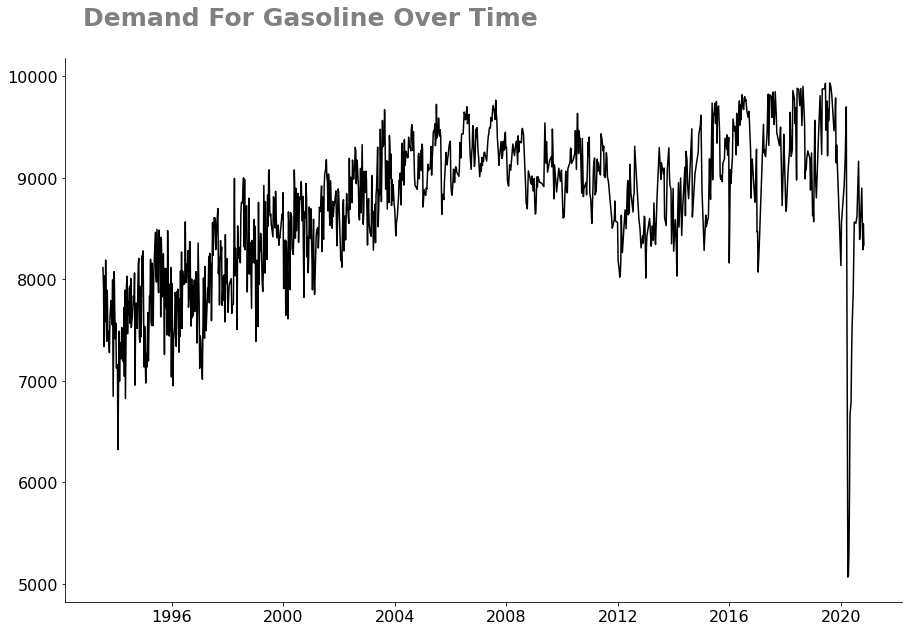

In [209]:
plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(df.index, df.demand, color = "black")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelsize = 16)
plt.text(s = "Demand For Gasoline Over Time", fontsize = 25, color = "gray", weight = "bold", x = 727500, y = 10500)
plt.show()

Here I generated a line chart showing the demand for gasoline over the time. But it is hard to analyze it and realize any pattern. So I will generate another one but grouped by year.

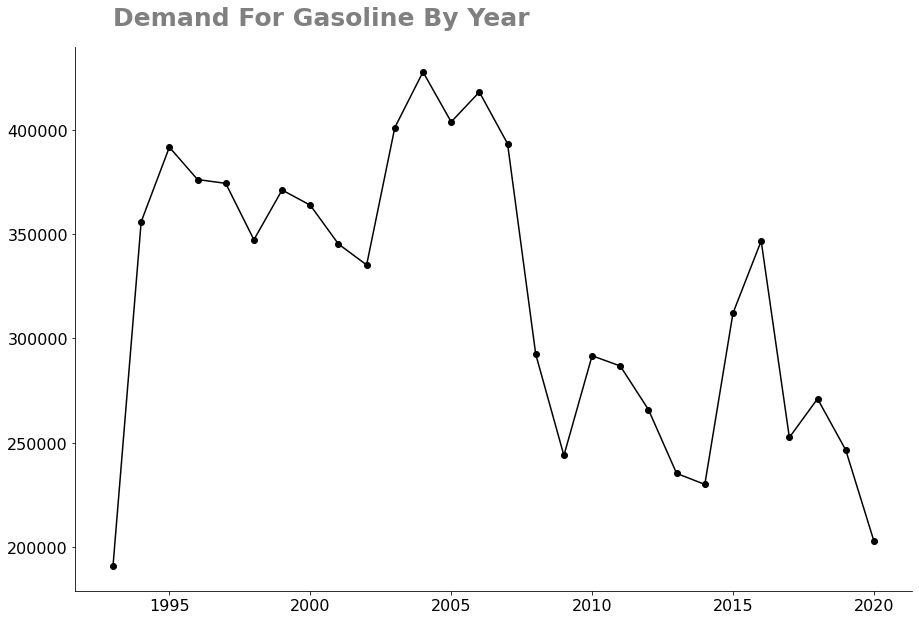

In [115]:
gr_dt = df.groupby(df.index.year).sum()
plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(gr_dt.index, gr_dt.demand, color = "black", marker = "o")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelsize = 16)
plt.text(s = "Demand For Gasoline By Year", fontsize = 25, color = "gray", weight = "bold", x = 1993, y = 450000)
plt.show()

Now it is easier to analyze this chart. But there is any seasonal pattern in this data, so it will not be necessary to use seasonal models.

# Model

Now it is time to start building the model. The statistical method I will be using to forecast the demand is called Autoregressive Integrated Moving Average (ARIMA). This is the next level of ARMA but for more complex time series.
 
## Evaluation Metrics
 
It is necessary to validate the results of any model, and data scientists use metrics to do it. There are many metrics for Regression. But I will be using the Mean Absolute Percentage Error, because it is very easy to understand and easy to calculate. 

But Python Scikit-Learn (software I am using) does not provide this metric, so it is necessary to create a function to do it.

In [116]:
def mape(actual, pred):
   return np.mean(np.abs((actual - pred) / actual)) * 100

## Training The Model

In [210]:
model = ARIMA(df.demand, order = (10, 1, 1)).fit()
acc = mape(df.demand, model.predict(typ = "levels"))
print("Mean Absolute Percentage Error: ", acc)

Mean Absolute Percentage Error:  2.8207646856441606


The best configuration for this model is (10, 1, 1) with a MAPE of 2,82. This means that this model is 97% correct while forecasting.
 
But if you are not so good to understand it by  numbers, there are other ways to evaluate this model by analyzing the actual values and predicted values in a line chart, like below:

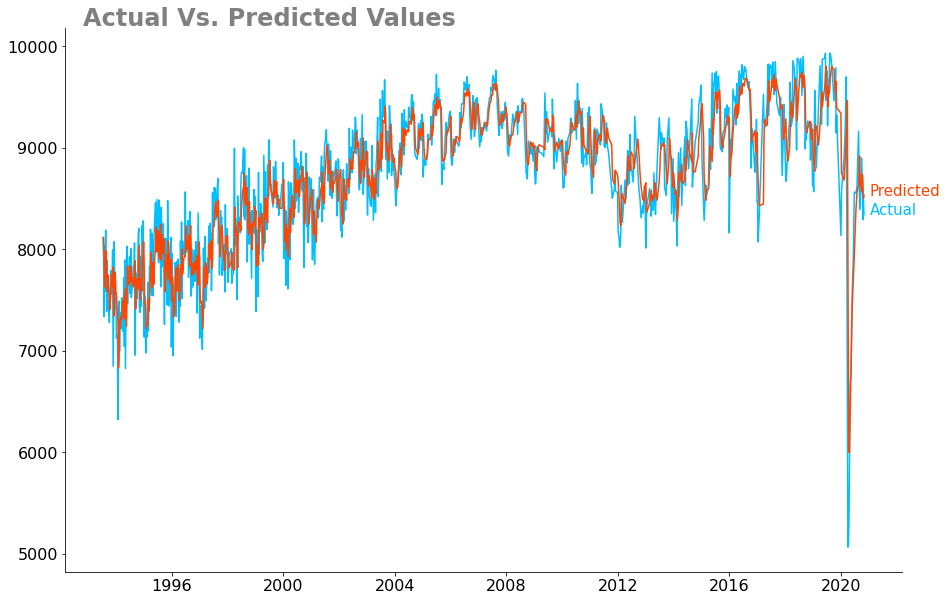

In [190]:
fig, ax = plt.subplots(figsize = (15, 10))
actual = ax.plot(df.demand, color = "deepskyblue")
pred = ax.plot(model.predict(typ = "levels"), color = "orangered")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelsize = 16)
 
plt.text(s = "Actual Vs. Predicted Values", x = 727500, y = 10200, fontsize = 24, weight = "bold", color = "gray")
plt.text(s = "Actual", x = 737800, y = df.demand[-1], color = "deepskyblue", fontsize = 15)
plt.text(s = "Predicted", x = 737800, y = model.predict(typ = "levels")[-1], color = "orangered", fontsize = 15)
 
plt.show()

It is possible to see that the models'fit is not 'perfect', but it is good, cause the model may work well when dealing with unseen data, what we want.

# Forecasting
 
We trained the model to know the demand for gasoline in the future.
 
We can not use the model to forecast many times because the prediction will be bad, but the dataset is big, so we can choose a good number.
 
I will choose 24 iterations with an alpha of 0.01 (confidence interval of 99%) to make sure I will get good predictions.

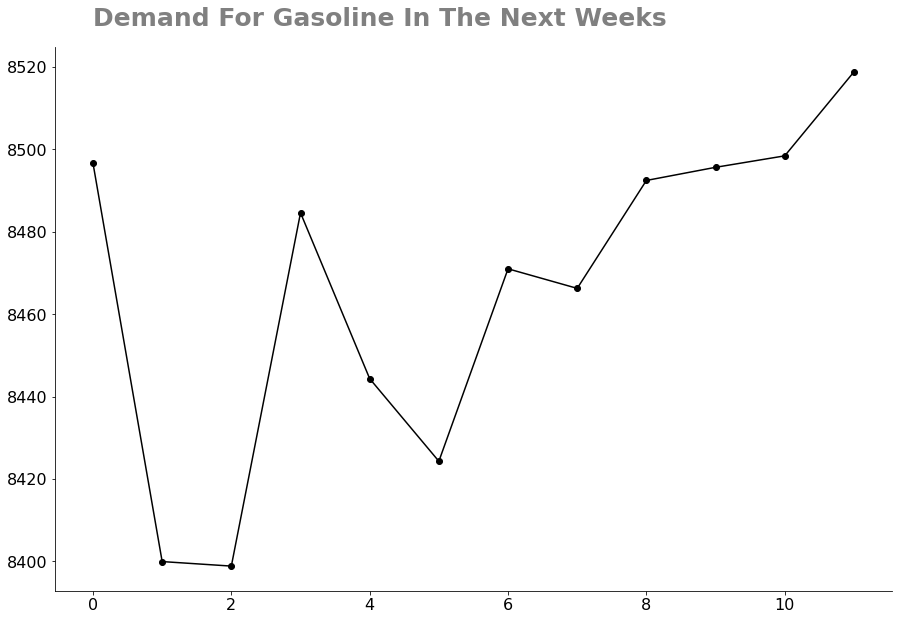

In [213]:
forecasting = model.forecast(12, alpha = 0.01)[0]
 
plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(forecasting, color = "black", marker = "o")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelsize = 16)
 
plt.text(s = "Demand For Gasoline In The Next Weeks", x = 0, y = 8530, fontsize = 25, color = "gray", weight = "bold")
 
plt.show()

#Deploy
 
In order to make the results more avaiable, I deployed this model as a Telegram Chatbot I called GasBot (@gasforecasting_bot). Anyone may access it and see the results.
 
The only thing you need to do is start a chat with it and enter */return* and then it will return a plot with the predictions for the next weeks.

Make yourself at home to do it.